# Искусственный интеллект

## NLP - Natural language processing

Работаем с [датасет](\datasets\toxic.csv), который содержит 160.000 комментариев, где какие-то из них помеченых оценщиками, как токсичное поведение \
Разные платформы  имеют разные критерии определения токсичности комментариев, поэтому комментарии помечаются
следующими категориями: **toxic**, **severe_toxic**, **obscene**, **threat**, **insult**, **identity_hate**

### Task 1

Нарисуем *Bar-plot* с количеством комментариев для каждой категории токсичности и комментариев без токсичности \
Выведем для каждой категории посчитаное количество комментариев 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import roc_auc_score
from scipy.sparse import csr_matrix
from scipy.sparse import hstack

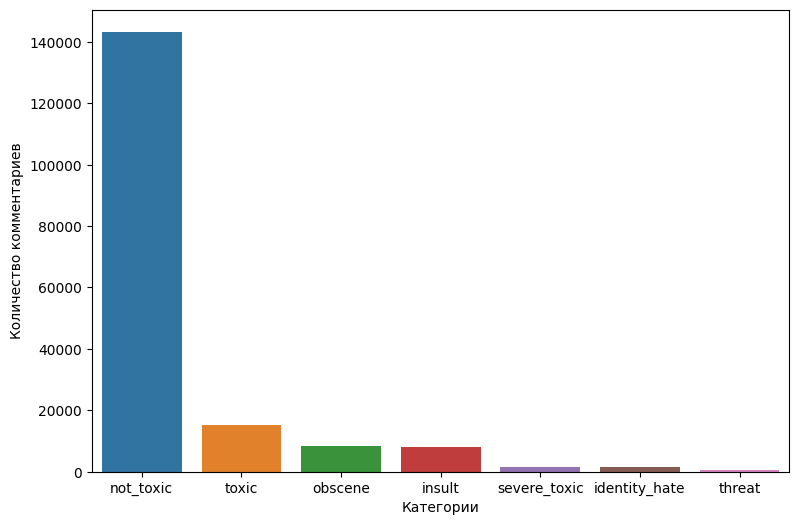

not_toxic        143346
toxic             15294
obscene            8449
insult             7877
severe_toxic       1595
identity_hate      1405
threat              478
dtype: int64


In [2]:
df_comm = pd.read_csv('../datasets/toxic.csv', low_memory=False)
df_comm['not_toxic'] = np.where(np.sum(df_comm[df_comm.columns.values[2:]], axis=1) == 0, 1, 0) # добавляем столбец 'not_toxic' c 1, если ни в
                                                                                                # одном столбце нет 1 т.е. комент не токсик
#df_comm[30:50]
df_sum = df_comm.iloc[:, 2:].sum().sort_values(ascending=False)
#df_sum[:]

plt.figure(figsize = (9,6))
sns.barplot(x=df_sum.index, y=df_sum.values)
plt.xlabel('Категории')
plt.ylabel('Количество комментариев')
plt.show()
print(df_sum)

### Task 2

Обработаем тексты комментариев, используя библиотеку *nltk*: 
* уберём стоп-слова из библиотеки *nltk*;
* приведём к нижнему регистру;
* уберём знаки препинания и цифр;
* токенизируем, т.е. разбиваем на слова (токены);
* оставляем только английские слова, т.е. буквенные токены

Выведем количество токенов в комментарии с индексом `000103f0d9cfb60f`

In [3]:
stop_words = stopwords.words('english')

def text_processing (text):
    text_tok = text.lower() # приводим к нижнему регистру
    text_tok = nltk.word_tokenize(text_tok) # разбиваем на токены по словам
    text_tok = [word for word in text_tok if word.isalpha()] # оставляем только буквенные токены
    text_tok = [w for w in text_tok if not w in stop_words] # удаляем стоп-слова
    return text_tok

df_comm['text_token'] = df_comm['comment_text'].apply(text_processing) # добавляем в df_comm столбец с токенами комментов
#df_comm

print('Количество токенов для комментария с индексом 000103f0d9cfb60f -',
      len(df_comm[df_comm['id'] == '000103f0d9cfb60f'].iloc[0]['text_token']))

Количество токенов для комментария с индексом 000103f0d9cfb60f - 9


### Task 3

Разделим выборку на тестовую и тренировочную, процент тестовой выборки 30% \
Используя матрицу функций *TF-IDF* с количеством признаков 3000 - преобразуем тексты комментариев \
Выведем размерность тренировочной выборки после преобразования

In [4]:
df_comm['text_token_j'] = [' '.join(i) for i in df_comm['text_token']] # объединим список токенов комента в строку и заносим в столбец df_comm
x = df_comm['text_token_j']
y = df_comm.iloc[:, 2:-2] # y - столбцы с 0 и 1 (токсич. нетоксич. коммент)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=21, test_size=0.3, shuffle=True)

tf_idf = TfidfVectorizer(max_features=3000)
x_train_tfidf = tf_idf.fit_transform(x_train)

print('Размерность тренировочной выборки -', x_train_tfidf.shape)

Размерность тренировочной выборки - (111699, 3000)


### Task 4

Используя регрессию *RidgeClassifier* решим задачу классификации по нескольким меткам *Multi-Label* и посчитаем значение метрики `ROC-AUC` для оценки тестовой выборки

In [5]:
r_clf = RidgeClassifier()
r_clf.fit(x_train_tfidf, y_train)

x_test_tfidf = tf_idf.transform(x_test)
y_pred = r_clf.predict(x_test_tfidf)

print('Значение ROC-AUC для тестовой выборки -', roc_auc_score(y_test, y_pred))

Значение ROC-AUC для тестовой выборки - 0.6641802122415228


### Task 5

Добавим к признакам матрицы *TF-IDF* ещё 4 признака, которые часто свойственны токсичным камментариям: 
* часто встречаются `!`;
* большое количество знаков пунктуации;
* написание текста `CapsLock`;
* большое количество символов (`@`, `*`, `&` и пр.)

Снова обучим модель и посчитаем значение метрики `ROC-AUC` для оценки новой выборки


In [6]:
df_tox = df_comm.loc [:, :'identity_hate']

def tox_processing (text):
    tox_tok = nltk.word_tokenize(text)
    return tox_tok

df_tox['text_token'] = df_tox['comment_text'].apply(tox_processing)
df_tox['text_token_j'] = [' '.join(i) for i in df_tox['text_token']]
xt = df_tox['text_token_j']
yt = df_tox.iloc[:, 2:-2]
#df_tox

xt_train, xt_test, yt_train, yt_test = train_test_split(xt, yt, random_state=21, test_size=0.3, shuffle=True)
tfidf_t = TfidfVectorizer(max_features=3000)
xt_train_tfidf = tfidf_t.fit_transform(xt_train)
#xt_train_tfidf

# создаём нов. признаки
exclam_train = df_tox.loc[xt_train.index]['comment_text'].apply(lambda x: x.count('!')) # 1.восклицательные знаки
exclam_test = df_tox.loc[xt_test.index]['comment_text'].apply(lambda x: x.count('!'))
punct_train = df_tox.loc[xt_train.index]['comment_text'].apply(lambda  x: sum(x.count(w) for w in '.,;:?')) # 2.пунктуация
punct_test = df_tox.loc[xt_test.index]['comment_text'].apply(lambda  x: sum(x.count(w) for w in '.,;:?'))
upperc_train = df_tox.loc[xt_train.index]['comment_text'].apply(lambda x: sum(1 for c in x if c.isupper())) # 3.CapsLock
upperc_test = df_tox.loc[xt_test.index]['comment_text'].apply(lambda x: sum(1 for c in x if c.isupper()))
symbol_train = df_tox.loc[xt_train.index]['comment_text'].apply(lambda  x: sum(x.count(w) for w in '@_*&$%')) # 4.особые символы
symbol_test = df_tox.loc[xt_test.index]['comment_text'].apply(lambda  x: sum(x.count(w) for w in '@_*&$%'))
#exclam_train, punct_train, upperc_train, symbol_train

new_train = csr_matrix(np.array([exclam_train, punct_train, upperc_train, symbol_train]).T) #создали и транспонировали матрицу нов. признаков
new_test = csr_matrix(np.array([exclam_test, punct_test, upperc_test, symbol_test]).T)
union_train = hstack((x_train_tfidf, new_train)) # объединили признаки TF-IDF и нов.
union_test = hstack((x_test_tfidf, new_test))
rnew_clf = RidgeClassifier() # снова обучаем модель с нов. признаками
rnew_clf.fit(union_train, yt_train)
yt_pred = rnew_clf.predict(union_test)

print('Значение ROC-AUC для новой выборки -', roc_auc_score(yt_test, yt_pred))

Значение ROC-AUC для новой выборки - 0.6510125441758036
